In [10]:
#%%
import numpy as np
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import numba as nb
import sys
import os

sys.path.insert(0, os.path.realpath('./transport/'))

from transport import tallies
from transport import material_definitions
from transport import functions_for_transport

from transport import functions_for_scattering_theory as xs


In [11]:
%matplotlib widget

### Match Benchmark
Plot and print out values


Incorrect statement:
"Since the value of ν is 0 for the capture isotope, the total fission cross section is given only by the fission isotope."

In [15]:
resonance_ladder_pu9 = pd.DataFrame({'E'    :   [2.956242e-1],
                                'Gn'    :   [7.947046e-5],
                                'Gg'    :   [3.982423e-2],
                                'Gf'    :   [5.619673e-2]})

pair_constants_pu9 = {
'ac':9.41e-4,             # 1e-12cm
'p0':0.002196807122623 * 1/2 ,   # 1 / 1e-12cm - sqrt(eV)
'gj':3/4,
}

resonance_ladder_u8 = pd.DataFrame({'E'    :    [6.674280e0],
                                    'Gn'    :   [1.492300e-3],
                                    'Gg'    :   [2.271100e-2],
                                    'Gf'    :   [9.880000e-9]})

pair_constants_u8 = {
'ac':9.48e-4,             # 1e-12cm
'p0':0.002196807122623 * 1/2 ,   # 1 / 1e-12cm - sqrt(eV)
'gj':1,
}

Npu9 = 1
Nu8 = 0.124954
Nscat = 0.008340505

pu9 = material_definitions.isotope(pair_constants_pu9, resonance_ladder_pu9, Npu9, 2.88)
u8 = material_definitions.isotope(pair_constants_u8, resonance_ladder_u8, Nu8, 0)

mat = material_definitions.material([pu9,u8], constant_scattering=20*Nscat)



In [16]:

benchmark_e = np.array([0.00001, 0.01000, 0.29562, 6.67425, 100.000, 2.0e7])
# benchmark_e = np.array([6.67425])
# energy = np.logspace(-5,7, 1000)
energy = benchmark_e


pu9_Sig_t, pu9_Sig_f, pu9_Sig_g, pu9_Sig_s = pu9.get_macro_cross_sections(energy)
u8_Sig_t, u8_Sig_f, u8_Sig_g, u8_Sig_s = u8.get_macro_cross_sections(energy)

m_Sig_t, m_Sig_f, m_Sig_g, m_Sig_s = mat.get_macro_cross_sections(energy)


if np.array_equal(energy,benchmark_e):
    print(f'fission:\n {m_Sig_f}')
    print(f'scattering:\n {m_Sig_s}')
    print(f'total:\n {m_Sig_t}')
else:
    figure()
    plot(energy, m_Sig_f, label='fission')
    # plot(energy, mat_gam, label='gamma')
    plot(energy, m_Sig_s, label='scattering')
    plot(energy, m_Sig_t, label='total')

    plot(energy, u8_Sig_t, label='U8 tot')

    xscale('log'); yscale('log')
    legend()

fission:
 [5.65557218e+04 1.91222922e+03 1.27783998e+04 1.57507609e-01
 1.61363598e-04 8.96724687e-18]
scattering:
 [6.30411682e-01 6.62484244e-01 1.82397786e+01 7.41464369e+02
 1.66859524e-01 1.66822639e-01]
total:
 [9.66652855e+04 3.26896822e+03 2.18523405e+04 1.20233909e+04
 1.67184247e-01 1.66822639e-01]


In [5]:
#### problem 4
N = 1.5e2
G=5
iE = 200
print(f'Particle Histories: {N}')
print(f'Energy Bins: {iE}')

Emin = 1e-5
Emax = 2e7 
iEbins = 200
tally = tallies.tallies(Emin, Emax, iEbins)

# option to set seed
rng = np.random.default_rng()


Particle Histories: 150.0
Energy Bins: 200


In [6]:
#### Could try to run as a vector - later when I want to speed this up
# E0 = rng.uniform(low=tally.Emin, high=tally.Emax, size=(1,2))
# E0 < np.full_like(E0, tally.Emin)
# E_new = Eigen_function_0D_CE(E0, tally, mat, rng)


#### Run transport

In [7]:
for g in range(int(G)):

    tally.reset_generation_tally()
    
    for iN in range(int(N)):
        #random fission energy
        E_start = rng.uniform(low=tally.Emin, high=tally.Emax) 
        # transport
        E_new = functions_for_transport.Eigen_function_0D_CE(E_start, tally, mat, rng)
    
    # save generation tally
    tally.save_generation_tally(N)
    
   
final_k_estimate, final_estimator_variance, collision_based_scalar_flux = tally.final_analysis() 

print(final_k_estimate, final_estimator_variance)


1.548 0.0375588427226754


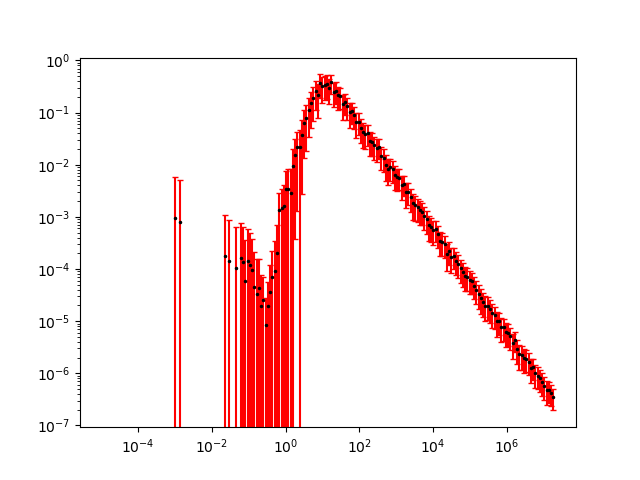

In [8]:

# %%
figure()
errorbar(tally.Ebins, collision_based_scalar_flux[0], yerr=np.sqrt(collision_based_scalar_flux[1]), 
                                                            fmt='.', color='k', ms=3, ecolor='r', capsize=2)

xscale('log')
yscale('log')


In [9]:
tally.first_moment/N

1.5933333333333333